# **Disciplina CAT010** - Aplicações dos Satélites em Ciências Atmosféricas


---

## **Aula Prática 5 - Parte 3:** $\underline{Plotando\ e\ Analisando\ Relâmpagos\ Estimados\ pelo\ Satélite\ GOES-16}$
---
**OBJETIVO:** Nesta aula prática aprenderemos como trabalhar com dados de relâmpagos estimado por satélite. Para isto usaremos os dados do sensor [Geostationary Lightning Mapper (GLM)](https://space.oscar.wmo.int/instruments/view/glm) abordo do satélite [Geostationary Operational Environmental Satellite - 16 (GOES-16)](https://space.oscar.wmo.int/satellites/view/goes_16). O objetivo dessa **Parte 3** é aprender como plotar e analisar mapas médios mensais, sazonais e anuais de relâmpagos para o Brasil.

---


**DADOS DE ENTRADA**: Arquivos de relâmpagos.

1. $\underline{Dados\ de\ Relâmpagos}$: sensor GLM do satélite GOES-16
- **Tipo do dado:** matriz de 1664 linhas por 1664 colunas
- **Formato do dado:** arquivo NETCDF
- **Nome do arquivo:** flash_goes16_mensal_2018-01.nc
- **Fonte dos dados:** Gerado pelo Prof. Enrique Mattos


---

**DADOS DE SAÍDA:** .
- **Tipo do dado:** Figura
- **Formato do dado:** arquivos JPG
- **Imagens geradas:**
    1. Fig_1_goes16_flash_anual.jpg
    2. Fig_2_goes16_flash_anual_Brasil.jpg
    3. Fig_3_goes16_flash_por_ano_Brasil.jpg
    5. Fig_4_goes16_flash_media_anual_Brasil.jpg
    6. Fig_5_goes16_flash_media_sazonal_Brasil.jpg
    7. Fig_6_goes16_flash_media_mensal_Brasil.jpg
---

**PROCEDIMENTO REALIZADO:** Os seguintes procedimentos são realizados nesse código:
1.   Instalação de bibliotecas
2.   Monta o google drive
3.   Define o caminho do google drive
4.   Importação das bibliotecas
5.   Carrega o GeoBR
6.   Conhecendo os dados de relâmpagos a cada **mensais** do sensor GLM
7.   Gerando mapas médio de flashes
     1. Leitura do dado
     2. Alguns gráficos básicos
     3. Alguns gráficos mais sofiscados e detalhados
        1. Área completa do satélite
        2. Área do Brasil com máscara
        3. Por ano
        4. Média Anual
        5. Média Sazonal
        6. Média Mensal


---
**OBSERVAÇÕES IMPORTANTES**:
1. Fazer mudanças, veja em: **### >>> MUDANÇAS AQUI <<< ###**
    - 1. Caminho do seu drive

---
- **Realizado por:** Enrique V. Mattos - 18/05/2022
- **Atualizado por:** Enrique V. Mattos - 08/11/2023


---


# **1° Passo:** Instalando as bibliotecas

In [ ]:
# Instalando o proplot (usado para gerar Mapas também)
!pip install -q proplot

# Instalando o cartopy (usado para gerar Mapas)
!pip uninstall shapely --yes
!pip install -q shapely cartopy==0.21.1 --no-binary shapely --no-binary cartopy
!wget https://raw.githubusercontent.com/SciTools/cartopy/master/tools/cartopy_feature_download.py
!python cartopy_feature_download.py physical

Chegando aqui, será necessário fazer a **Reinicialização do Ambiente de Execução** (acessar *Ambiente de execução* que esta na barra de ferramentas e clicar em *Reiniciar Ambiente de Execução* e rodar novamente a célula anterior de instalações) e ter que instalar todos os pacotes de novo. Isso é necessário tanto para poder usar sem problemas o `Proplot` quanto o `CartoPy` na nossa sessão do Colab, então a partir desse ponto não teremos mais que nos preocupar com a preparação do ambiente virtual.

In [ ]:
# Instalando a biblioteca Salem
!pip install rasterio -q
!pip install pyproj -q
!pip install geopandas -q
!pip install salem -q
!pip install descartes -q

# **2° Passo:** Montando drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **3° Passo:** Caminho do diretório

In [ ]:
dir = '/content/drive/MyDrive/1-AULAS/2022.2/CAT010 - PYTHON PARA SATELITES METEOROLOGICOS/AULA_05_RELAMPAGOS/'

# **4° Passo:** Importando as bibliotecas

In [ ]:
import proplot as plot
import time as t
import glob
import numpy as np
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import os
from time import process_time
import calendar
import salem
import xarray as xr
import pandas as pd

from datetime import timedelta, date, datetime
import imageio    # Python interface to read and write a wide range of image data

import sys
sys.path.append(f'{dir}')
from cpt_convert import loadCPT

from matplotlib.colors import LinearSegmentedColormap # interpolação linear para as cores dos mapas
from matplotlib import cm                           # Colormap handling utilities

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/proplot/config.py:1454: ProPlotWarning: Rebuilding font cache.


# **5° Passo:** Shapefiles
- Iremos utilizar os arquivos shapefiles do território brasileiro. Os dados serão baixados direto do meu [GitHub](https://github.com/evmpython/shapefile).

In [ ]:
# url
url = 'https://github.com/evmpython/shapefile/raw/main/'

# caminho completo do arquivo. Exemplo: !wget https://github.com/evmpython/shapefile/raw/main/BR_UF_2019.shp
file1 = f'{url}BR_UF_2019.cpg'
file2 = f'{url}BR_UF_2019.dbf'
file3 = f'{url}BR_UF_2019.prj'
file4 = f'{url}BR_UF_2019.shp'
file5 = f'{url}BR_UF_2019.shx'

# baixa o shapefile
!wget -c {file1}
!wget -c {file2}
!wget -c {file3}
!wget -c {file4}
!wget -c {file5}

# lendo shapefile de todos Estados do Brasil
estados = salem.read_shapefile('/content/BR_UF_2019.shp')
estados

# **PARTE 1)**: Conhecendo os dados de relâmpagos a cada **mensais** do sensor GLM

##**a) Nome do arquivo**
- Os arquivos são acumulados de flashes por mês. Esses arquivos foram gerados a partir dos dados a cada 5 min dos dados produzidos pelo [CPTEC/INPE](http://ftp.cptec.inpe.br/goes/goes16/goes16_web/glm_acumulado_nc/).

In [ ]:
# nome do arquivo
file_mensal = 'flash_goes16_mensal_2021-01.nc'

##**b) Leitura do arquivo**

In [ ]:
# leitura do arquivo
ds_mensal = xr.open_dataset(f'{dir}input/mensal/2021/{file_mensal}')

In [ ]:
# exibe os dados
ds_mensal

<xarray.Dataset>
Dimensions:  (time: 1, lat: 1664, lon: 1664)
Coordinates:
  * time     (time) datetime64[ns] 2021-01-31
  * lat      (lat) float32 -66.56 -66.48 -66.4 -66.32 ... 66.24 66.32 66.4 66.48
  * lon      (lon) float32 -141.6 -141.5 -141.4 -141.3 ... -8.68 -8.6 -8.52
Data variables:
    flash    (time, lat, lon) float32 ...

##**c) Exibindo os dados**

In [ ]:
# formato dos dados de flash
ds_mensal['flash'].shape

(1, 1664, 1664)

In [ ]:
# dados de flash
ds_mensal['flash']

<xarray.DataArray 'flash' (time: 1, lat: 1664, lon: 1664)>
[2768896 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2021-01-31
  * lat      (lat) float32 -66.56 -66.48 -66.4 -66.32 ... 66.24 66.32 66.4 66.48
  * lon      (lon) float32 -141.6 -141.5 -141.4 -141.3 ... -8.68 -8.6 -8.52

In [ ]:
# latitudes
ds_mensal['lat']

<xarray.DataArray 'lat' (lat: 1664)>
array([-66.56    , -66.479996, -66.399994, ...,  66.32    ,  66.4     ,
        66.48    ], dtype=float32)
Coordinates:
  * lat      (lat) float32 -66.56 -66.48 -66.4 -66.32 ... 66.24 66.32 66.4 66.48
Attributes:
    units:    degree_north

In [ ]:
# longitudes
ds_mensal['lon']

<xarray.DataArray 'lon' (lon: 1664)>
array([-141.56    , -141.48    , -141.4     , ...,   -8.679997,   -8.599998,
         -8.519998], dtype=float32)
Coordinates:
  * lon      (lon) float32 -141.6 -141.5 -141.4 -141.3 ... -8.68 -8.6 -8.52
Attributes:
    units:    degree_east

In [ ]:
# mostra a data do arquivo
ds_mensal['time'].values

array(['2021-01-31T00:00:00.000000000'], dtype='datetime64[ns]')

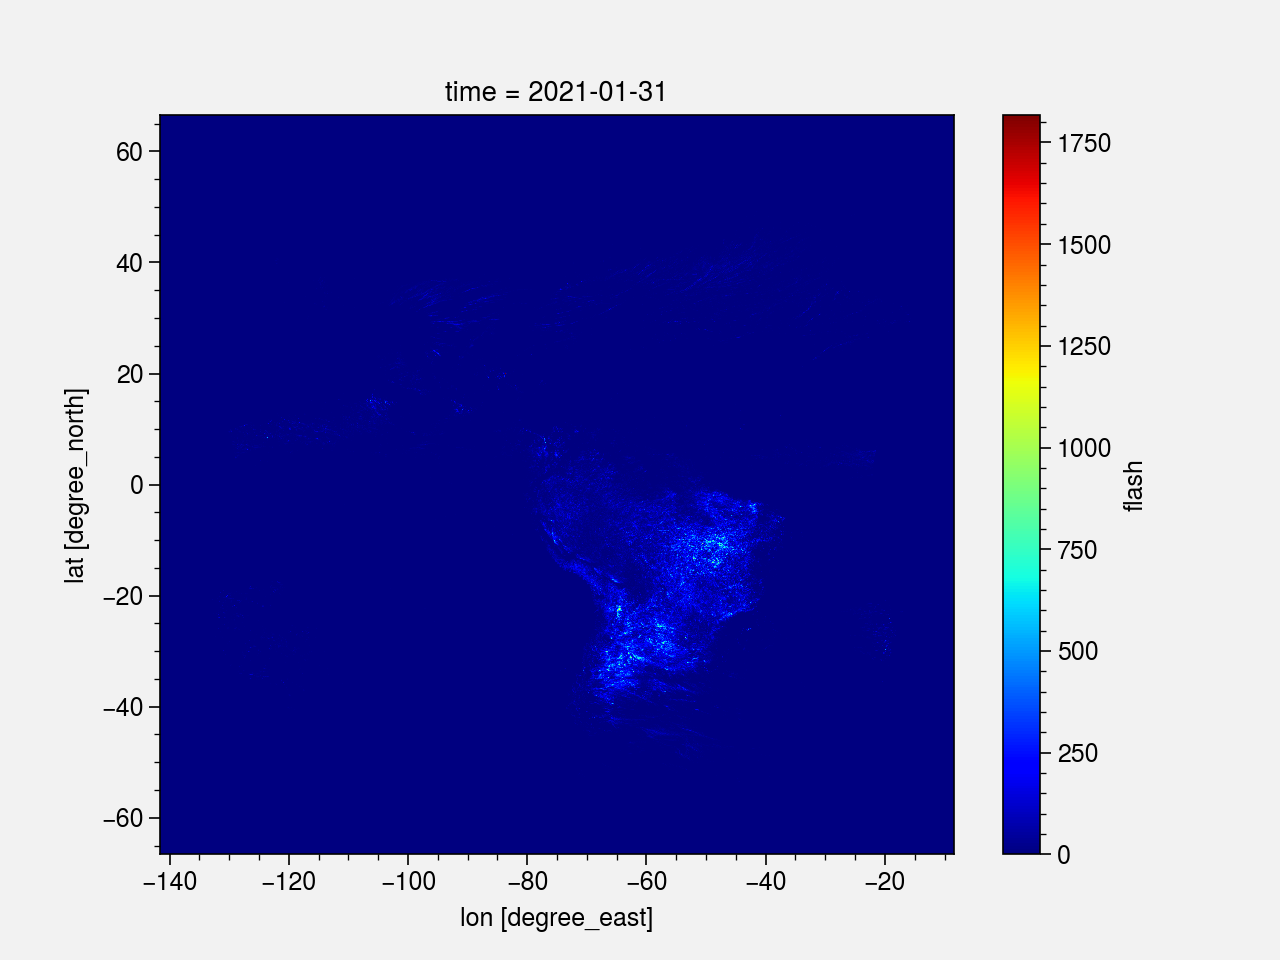

In [ ]:
# mapa simples
ds_mensal['flash'].plot(cmap='jet')

# **PARTE 2)**: Gerando mapas médio de flashes

##**a) Leitura do dado**

**Monta lista dos arquivos**

In [ ]:
# arquivos de 2018
files_2018 = sorted(glob.glob(f'{dir}input/mensal/2018/*nc'))

# arquivos de 2019
files_2019 = sorted(glob.glob(f'{dir}input/mensal/2019/*nc'))

# arquivos de 2020
files_2020 = sorted(glob.glob(f'{dir}input/mensal/2020/*nc'))

# arquivos de 2021
files_2021 = sorted(glob.glob(f'{dir}input/mensal/2021/*nc'))

# lista com todos arquivos
files = files_2018 + files_2019 + files_2020 + files_2021

# mostra na tela a lista de arquivos completa
files

**Leitura do dado**

In [ ]:
# leitura do dado
flash_por_mes = xr.open_mfdataset(files, concat_dim='time', combine='nested')

In [ ]:
# mostrando os dados
flash_por_mes

<xarray.Dataset>
Dimensions:  (time: 46, lat: 1664, lon: 1664)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-31 2018-02-28 ... 2021-12-31
  * lat      (lat) float32 -66.56 -66.48 -66.4 -66.32 ... 66.24 66.32 66.4 66.48
  * lon      (lon) float32 -141.6 -141.5 -141.4 -141.3 ... -8.68 -8.6 -8.52
Data variables:
    flash    (time, lat, lon) float32 dask.array<chunksize=(1, 1664, 1664), meta=np.ndarray>

In [ ]:
# mostrando os tempos
flash_por_mes['time']

<xarray.DataArray 'time' (time: 46)>
array(['2018-01-31T00:00:00.000000000', '2018-02-28T00:00:00.000000000',
       '2018-03-31T00:00:00.000000000', '2018-04-30T00:00:00.000000000',
       '2018-05-31T00:00:00.000000000', '2018-06-30T00:00:00.000000000',
       '2018-07-31T00:00:00.000000000', '2018-08-31T00:00:00.000000000',
       '2018-09-30T00:00:00.000000000', '2018-10-31T00:00:00.000000000',
       '2019-01-31T00:00:00.000000000', '2019-02-28T00:00:00.000000000',
       '2019-03-31T00:00:00.000000000', '2019-04-30T00:00:00.000000000',
       '2019-05-31T00:00:00.000000000', '2019-06-30T00:00:00.000000000',
       '2019-07-31T00:00:00.000000000', '2019-08-31T00:00:00.000000000',
       '2019-09-30T00:00:00.000000000', '2019-10-31T00:00:00.000000000',
       '2019-11-30T00:00:00.000000000', '2019-12-31T00:00:00.000000000',
       '2020-01-31T00:00:00.000000000', '2020-02-29T00:00:00.000000000',
       '2020-03-31T00:00:00.000000000', '2020-04-30T00:00:00.000000000',
       '2020-05-31T00:00:00.000000000', '2020-06-30T00:00:00.000000000',
       '2020-07-31T00:00:00.000000000', '2020-08-31T00:00:00.000000000',
       '2020-09-30T00:00:00.000000000', '2020-10-31T00:00:00.000000000',
       '2020-11-30T00:00:00.000000000', '2020-12-31T00:00:00.000000000',
       '2021-01-31T00:00:00.000000000', '2021-02-28T00:00:00.000000000',
       '2021-03-31T00:00:00.000000000', '2021-04-30T00:00:00.000000000',
       '2021-05-31T00:00:00.000000000', '2021-06-30T00:00:00.000000000',
       '2021-07-31T00:00:00.000000000', '2021-08-31T00:00:00.000000000',
       '2021-09-30T00:00:00.000000000', '2021-10-31T00:00:00.000000000',
       '2021-11-30T00:00:00.000000000', '2021-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2018-01-31 2018-02-28 ... 2021-12-31

##**b) Alguns gráficos básicos**

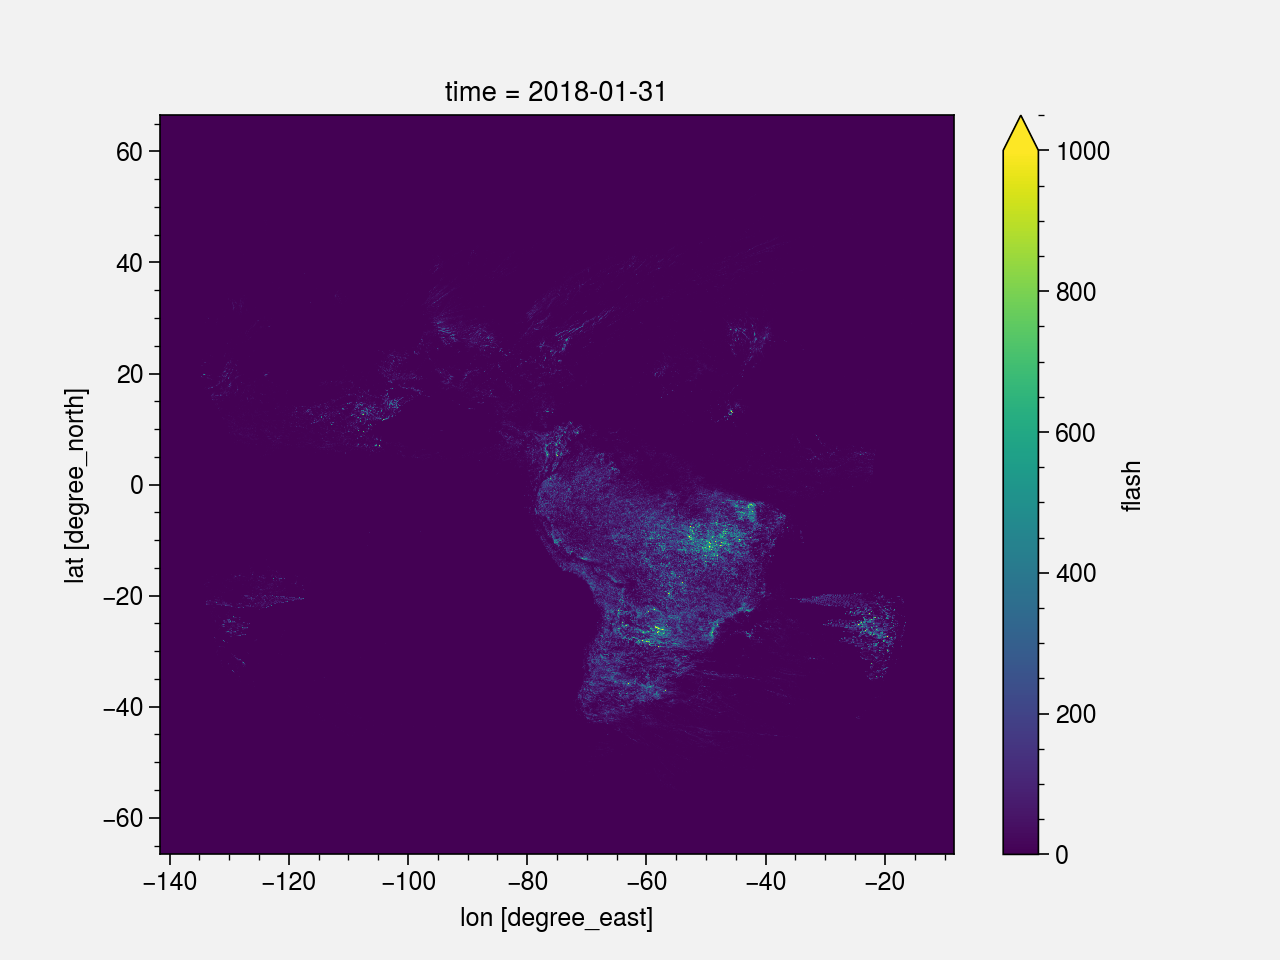

In [ ]:
# selecionando o mês pelo NOME
flash_por_mes['flash'].loc['2018-01-31T00:00:00.000000000'].plot(vmax=1000)

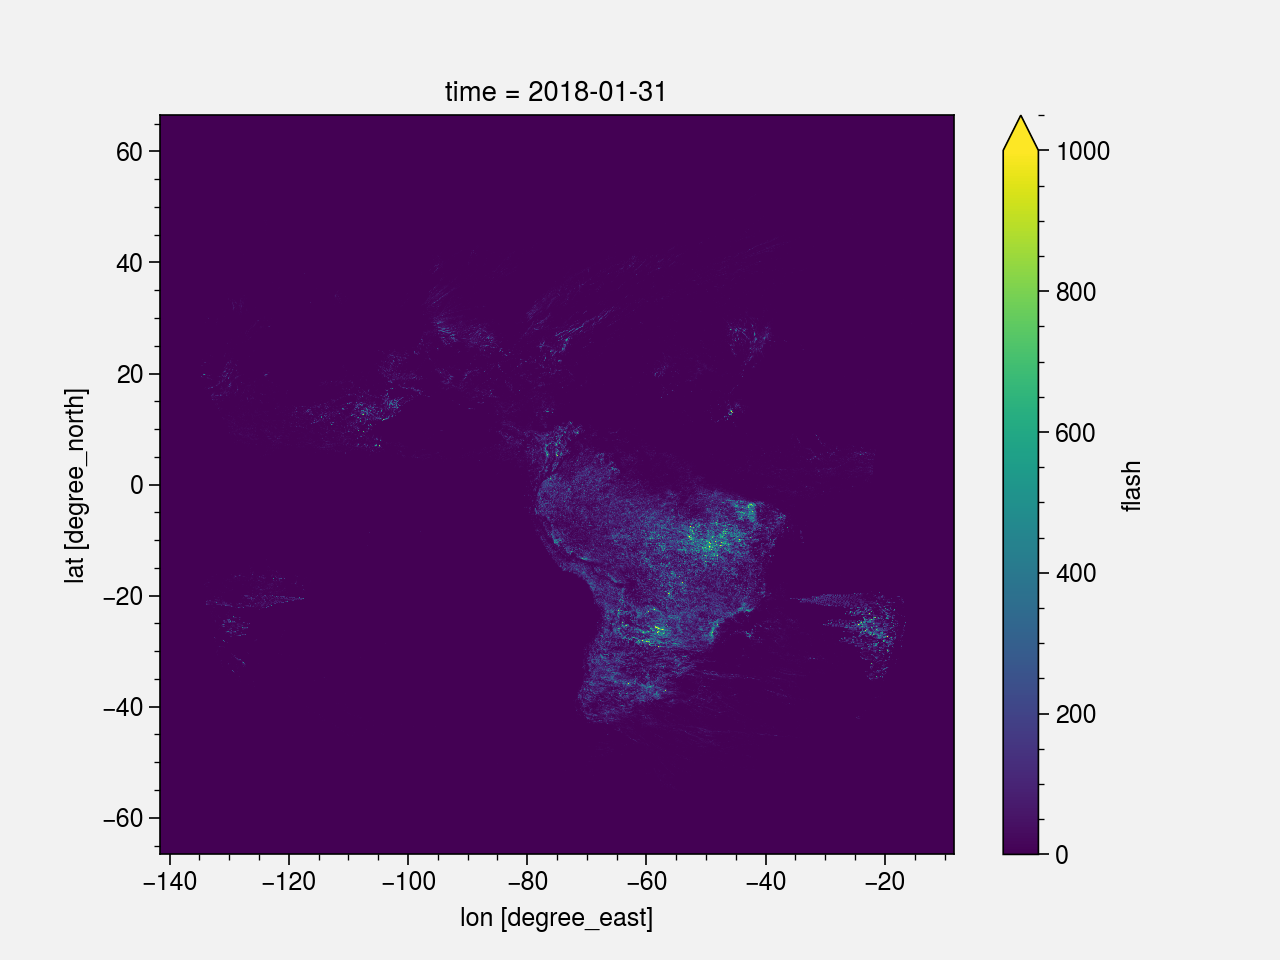

In [ ]:
# selecionando o mês pelo ÍNDICE
flash_por_mes['flash'].isel(time=0).plot(vmax=1000)

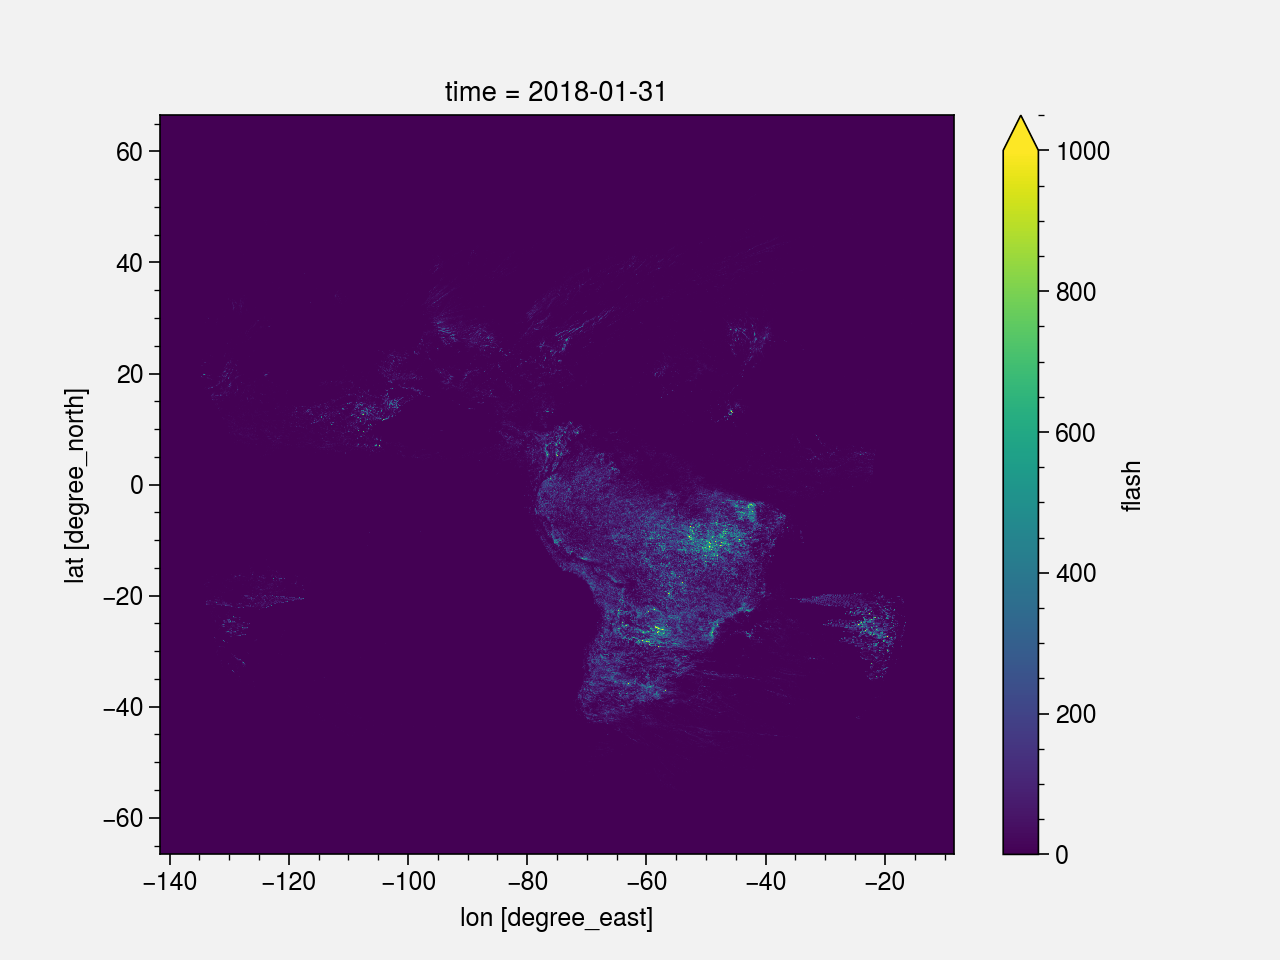

In [ ]:
# selecionando o mês pelo ÍNDICE da matriz
flash_por_mes['flash'][0, :, :].plot(vmax=1000)

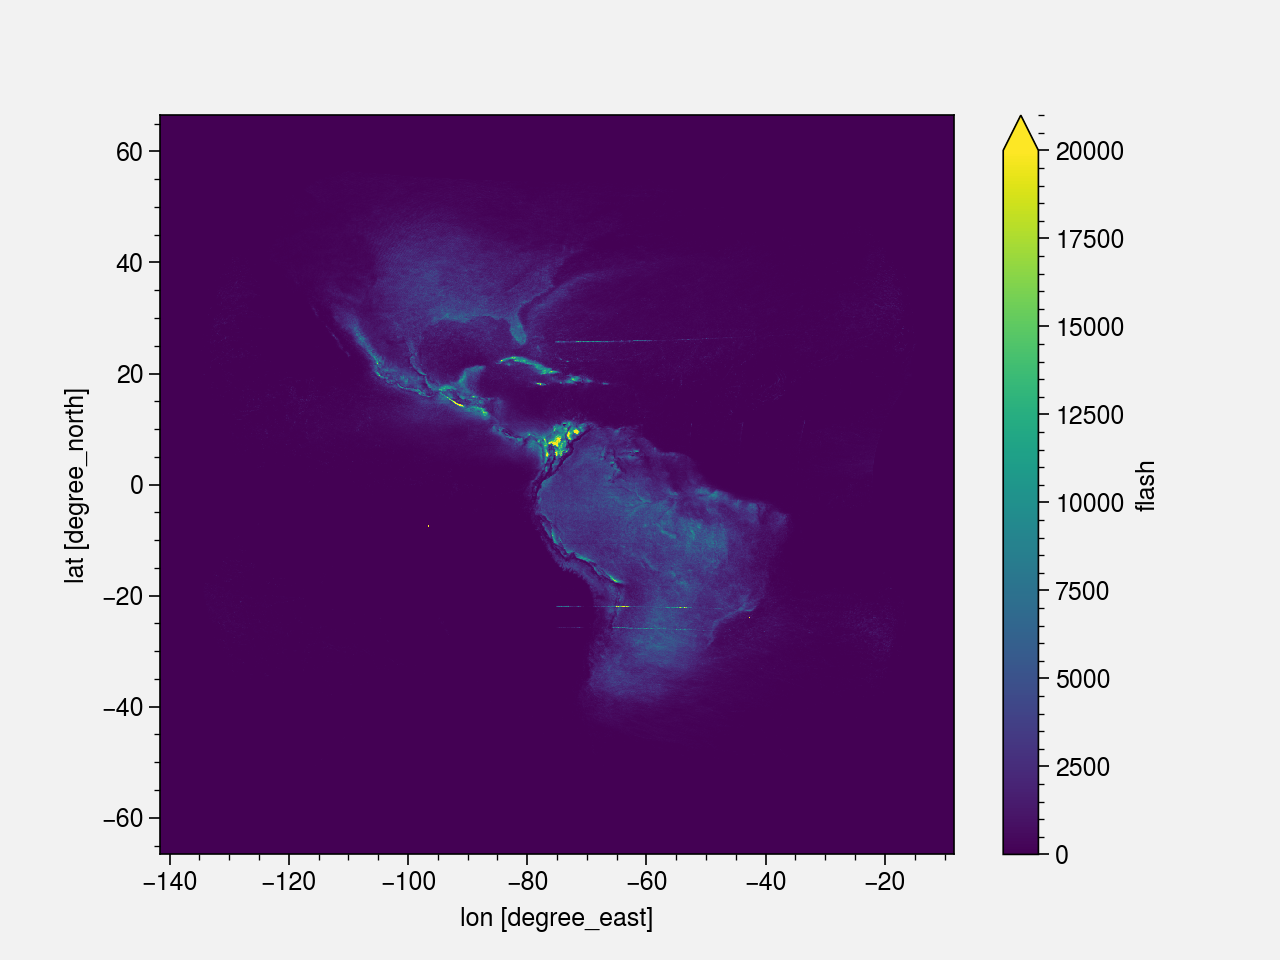

In [ ]:
# fazendo uma soma no tempo
flash_por_mes['flash'].sum(dim='time').plot(vmax=20000)

##**Alguns gráficos mais sofiscados e detalhados**

###**a) Área completa do satélite**

In [ ]:
# recorta o dado no tempo. Selecionaremos apenas os dados para o ano de 2021
flash_2021 = flash_por_mes.sel(time=('2021'))

In [ ]:
# mostra o dado recortado para 2021
flash_2021

<xarray.Dataset>
Dimensions:  (time: 12, lat: 1664, lon: 1664)
Coordinates:
  * time     (time) datetime64[ns] 2021-01-31 2021-02-28 ... 2021-12-31
  * lat      (lat) float32 -66.56 -66.48 -66.4 -66.32 ... 66.24 66.32 66.4 66.48
  * lon      (lon) float32 -141.6 -141.5 -141.4 -141.3 ... -8.68 -8.6 -8.52
Data variables:
    flash    (time, lat, lon) float32 dask.array<chunksize=(1, 1664, 1664), meta=np.ndarray>

In [ ]:
# limites da figura
lonmin = float(flash_2021['lon'].min())
lonmax = float(flash_2021['lon'].max())
latmin = float(flash_2021['lat'].min())
latmax = float(flash_2021['lat'].max())

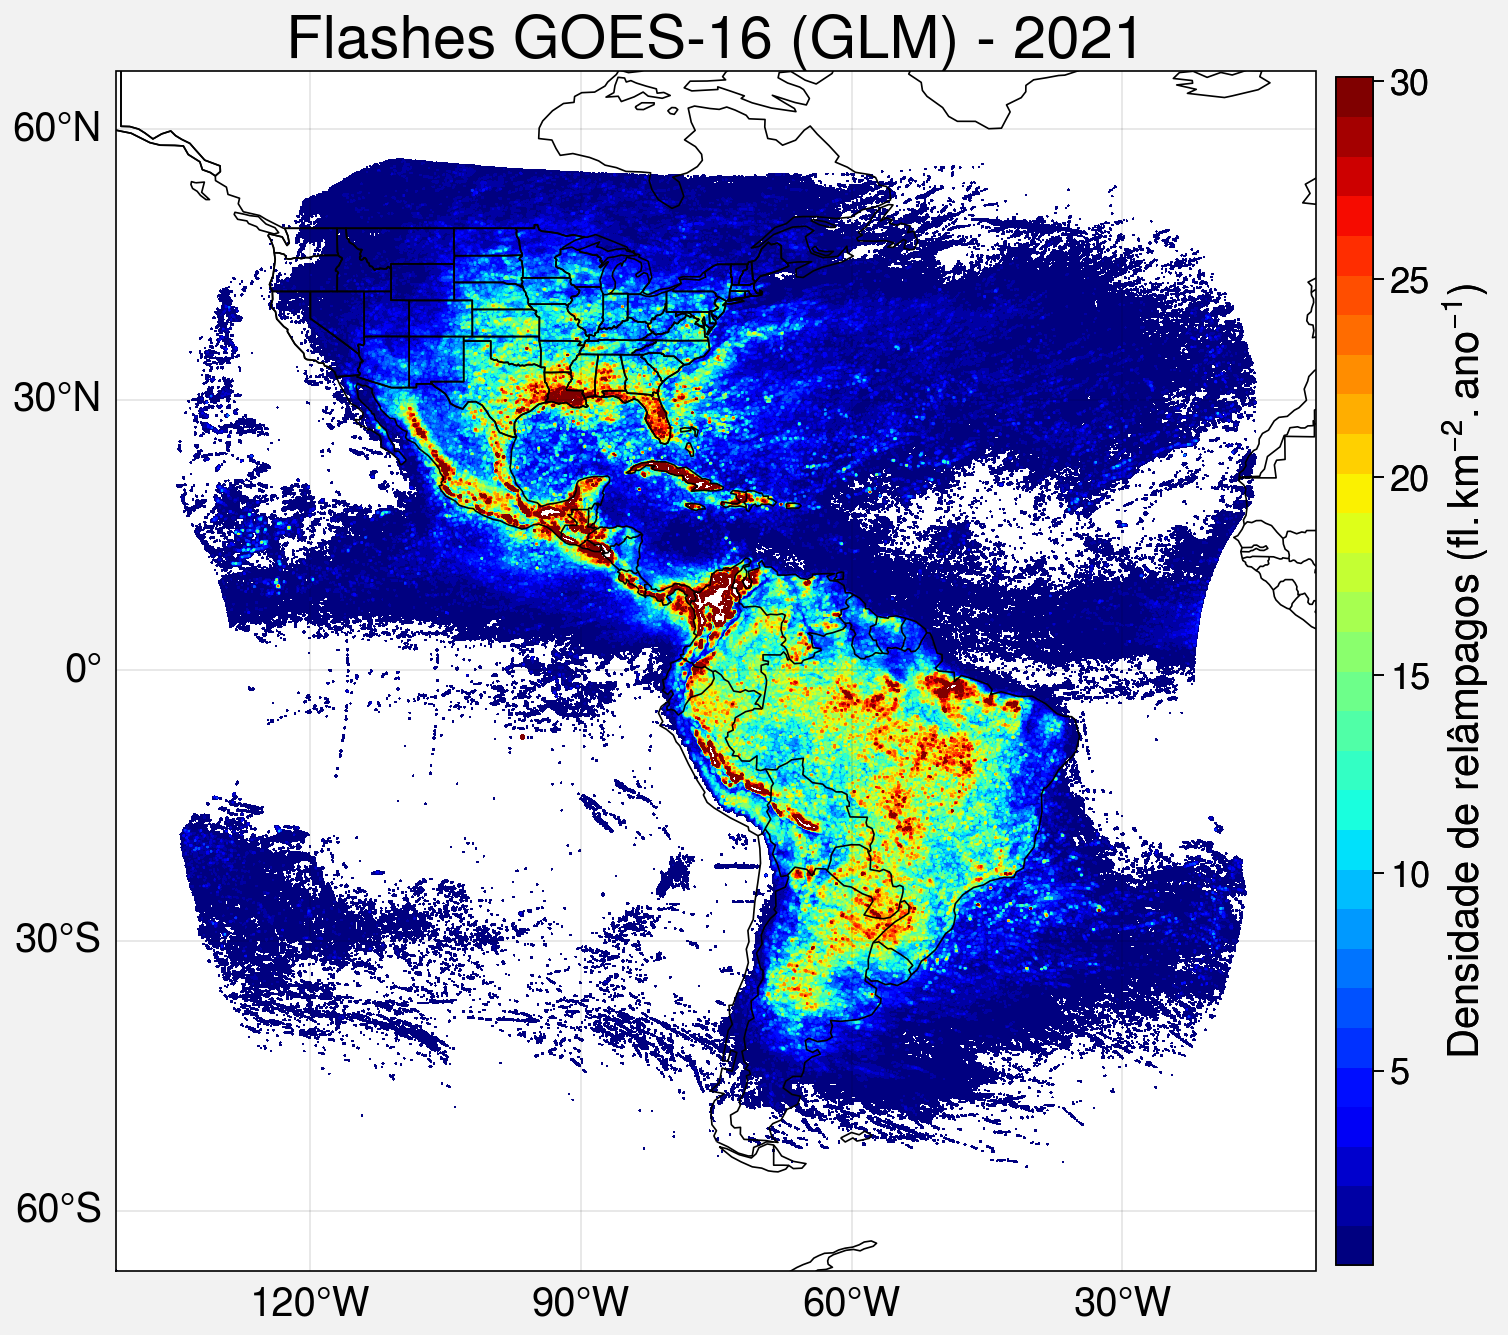

In [ ]:
# cria a moldura da figura
fig, ax = plot.subplots(axwidth=6, tight=True, proj='pcarree')

# define formato da figura
ax.format(coast=True, borders=True, innerborders=True,
          labels=True, latlines=30, lonlines=30,
          latlim=(latmin, latmax), lonlim=(lonmin, lonmax),
          title=f'Flashes GOES-16 (GLM) - 2021',
          small='20px', large='30px')

# plota mapa
map1 = ax.contourf(flash_2021['lon'],
                   flash_2021['lat'],
                   (flash_2021['flash'].sum(dim='time'))/64.,
                   cmap='jet',
                   vmin=0.1, vmax=30,
                   levels=plot.arange(0.1, 30., 1.0))

# plota barra de cores da figura
fig.colorbar(map1, loc='r', label='Densidade de relâmpagos $(fl.km^{-2}.ano^{-1})$',
             ticks=5, ticklabelsize=13, labelsize=15,
             space=0.1, length=0.99)

# salva figura
fig.save(f'{dir}output/parte_3/Fig_1_goes16_flash_anual.jpg', dpi=300)

###**b) Área do Brasil com máscara**

**Leitura do shapefile do Brasil**

In [ ]:
# lendo o shapefile usando a biblioteca Salem
shapefile_brasil = salem.read_shapefile(f'{dir}shapefiles/BRAZIL.shp')

In [ ]:
# mostra do shapefile lido
shapefile_brasil

ScaleRank  LabelRank     FeatureCla SOVEREIGNT SOV_A3  ADM0_DIF  LEVEL  \
0          1          2  Adm-0 country     Brazil    BRA       0.0    2.0   

                TYPE   ADMIN ADM0_A3  ...  GDP_MD_EST FIPS_10_ ISO_A2 ISO_A3  \
0  Sovereign country  Brazil     BRA  ...   1993000.0      0.0     BR    BRA   

  ISO_N3                                           geometry      min_x  \
0   76.0  MULTIPOLYGON (((-48.54186 -27.81670, -48.55117... -74.018475   

       max_x     min_y     max_y  
0 -28.876346 -33.74228  5.267225  

[1 rows x 29 columns]

**Plota figura**

In [ ]:
# limites do Brasil
lonmin, lonmax, latmin, latmax = -75.0, -32.0, -35.0, 7.0

In [ ]:
# fazendo o recorte do dado para o Brasil
flash_2021_brasil = flash_2021.sel(lat=slice(latmin, latmax), lon=slice(lonmin, lonmax))

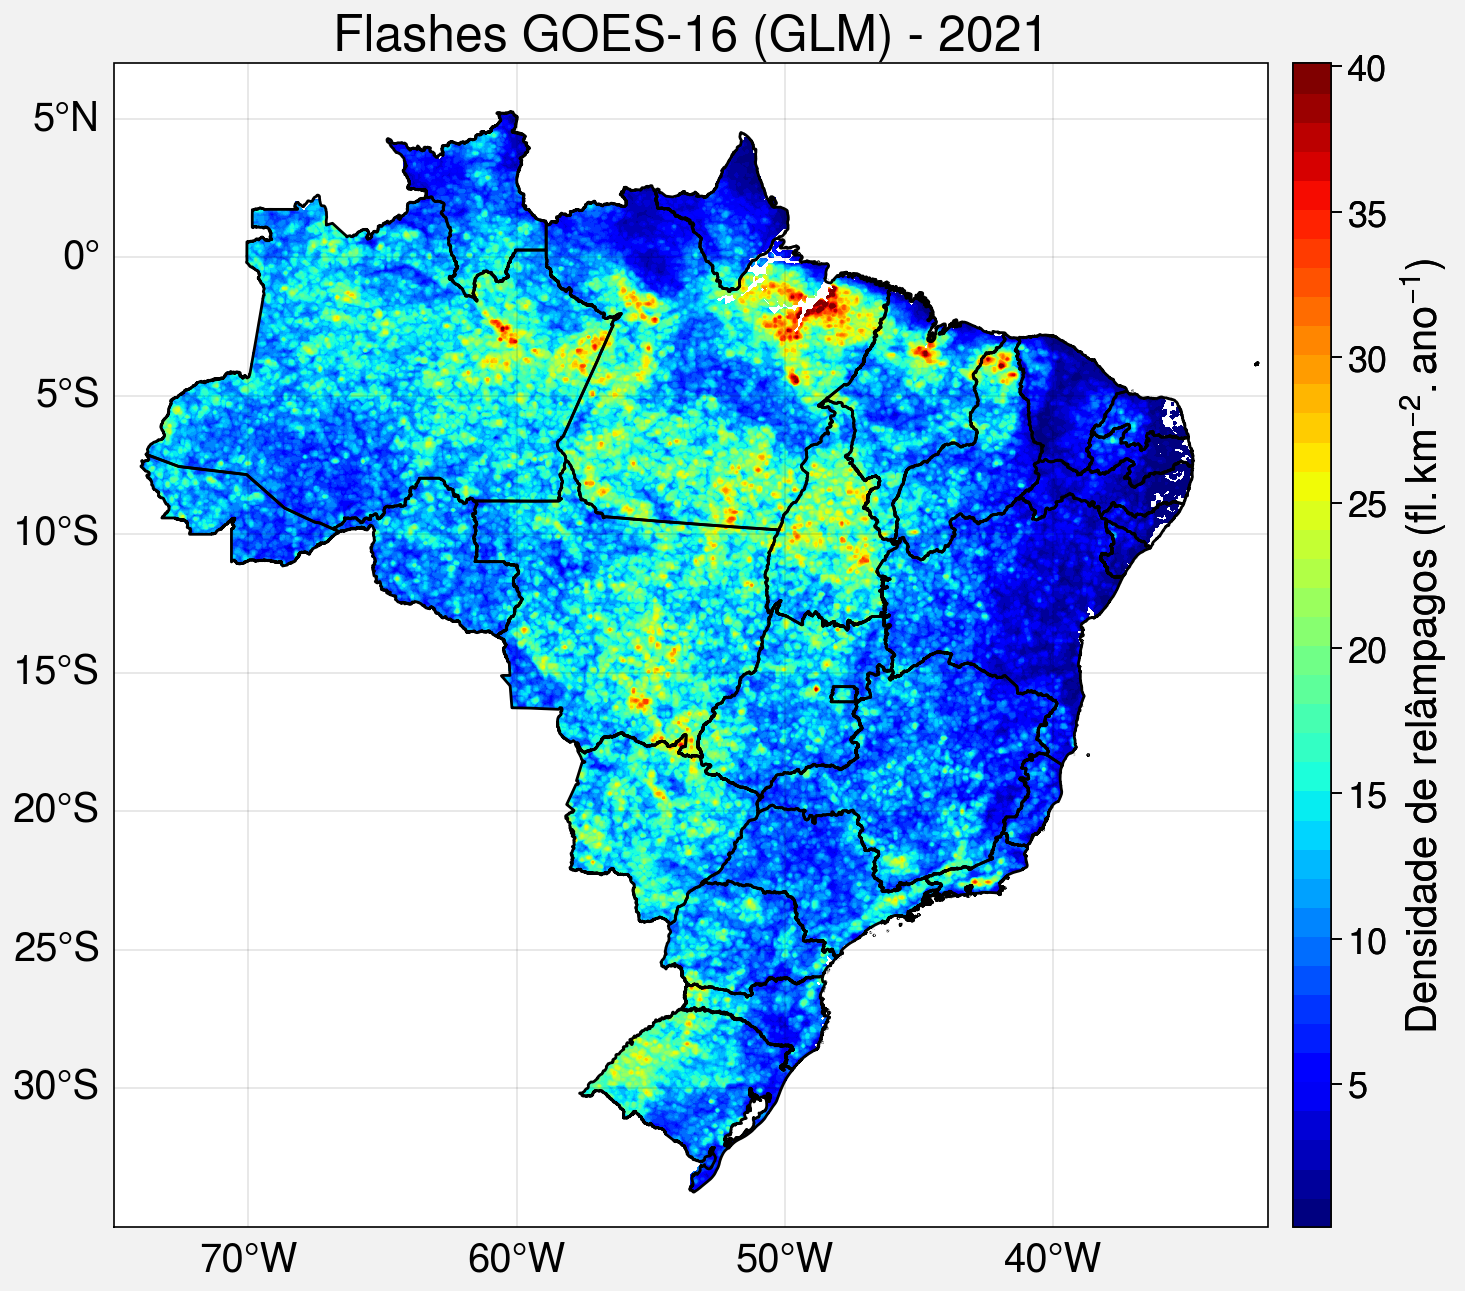

In [ ]:
# cria a moldura da figura
fig, ax = plot.subplots(axwidth=6, tight=True, proj='pcarree')

# define formato da figura
ax.format(coast=False, borders=False, innerborders=False,
          labels=True, latlines=5, lonlines=10,
          latlim=(latmin, latmax), lonlim=(lonmin, lonmax),
          title=f'Flashes GOES-16 (GLM) - 2021',
          small='20px', large='25px')

# plota mapa
map1 = ax.contourf(flash_2021_brasil['lon'],
                   flash_2021_brasil['lat'],
                   ((flash_2021_brasil['flash'].sum(dim='time'))/64.).salem.roi(shape=shapefile_brasil),
                   cmap='jet',
                   vmin=0.1, vmax=40,
                   levels=plot.arange(0.1, 40., 1.0))

# plota contorno dos Estados do Brasil
estados.plot(edgecolor='black', facecolor='none', linewidth=1, alpha=1, ax=ax)

# plota barra de cores da figura
fig.colorbar(map1, loc='r', label='Densidade de relâmpagos $(fl.km^{-2}.ano^{-1})$',
             ticks=5, ticklabelsize=13, labelsize=15)

# salva figura
fig.save(f'{dir}output/parte_3/Fig_2_goes16_flash_anual_Brasil.jpg', dpi=300)

###**c) Por ano**

**Gera estatísticas**

In [ ]:
# reamostra o dado
flash_por_ano = flash_por_mes['flash'].groupby('time.year').sum('time')

In [ ]:
# recorta o dado para região
flash_por_ano = flash_por_ano.salem.roi(shape=shapefile_brasil)

In [ ]:
# mostra o dado
flash_por_ano

<xarray.DataArray 'flash' (year: 4, lat: 1664, lon: 1664)>
dask.array<where, shape=(4, 1664, 1664), dtype=float32, chunksize=(1, 1664, 1664), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -66.56 -66.48 -66.4 -66.32 ... 66.24 66.32 66.4 66.48
  * lon      (lon) float32 -141.6 -141.5 -141.4 -141.3 ... -8.68 -8.6 -8.52
  * year     (year) int64 2018 2019 2020 2021
Attributes:
    pyproj_srs:  +proj=longlat +datum=WGS84 +no_defs

**Plota gráfico**

In [ ]:
# cria a moldura da figura
fig, ax = plot.subplots(figsize=(12,12), nrows=2, ncols=2, tight=True, proj='pcarree', sharex=True, sharey=True)

# formatação dos eixos
ax.format(coast=False, borders=False, innerborders=False,
          latlines=5, lonlines=10,
          latlim=(latmin, latmax), lonlim=(lonmin, lonmax),
          suptitle=f'Flashes GOES-16 (GLM): Por ano ({flash_por_ano.year[0].values}-{flash_por_ano.year[-1].values})',
          abc=True, abcstyle='a)', abcsize=5,
          small='25px', large='30px')

# loop das estações
for s in range(len(flash_por_ano)):

    # plota figura
    map1 = ax[s].contourf(flash_por_ano['lon'], flash_por_ano['lat'], flash_por_ano[s,:,:]/64.,
                          cmap='jet', levels=plot.arange(0.1, 40., 1.0),
                          extend='both')

    # plota titulo de cada figura
    if(s == 0): ax[s].format(title=flash_por_ano.year[s].values, labels = [True, False, False, False])
    if(s == 1): ax[s].format(title=flash_por_ano.year[s].values, labels = [False, False, False, False])
    if(s == 2): ax[s].format(title=flash_por_ano.year[s].values, labels = [True, False, True, False])
    if(s == 3): ax[s].format(title=flash_por_ano.year[s].values, labels = [False, False, True, False])

    # plota o contorno dos Estados do Brasil
    shapefile = list(shpreader.Reader(f'{dir}shapefiles/BR_UF_2019.shp').geometries())
    ax[s].add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='black',facecolor='none', linewidth=1.0)

# plota barra de cores da figura
fig.colorbar(map1, loc='r', label='Densidade de relâmpagos $(fl.km^{-2}.ano^{-1})$',
             ticks=5, ticklabelsize=13, labelsize=15, length=0.70)

# salva figura
fig.save(f'{dir}output/parte_3/Fig_3_goes16_flash_por_ano_Brasil.jpg', dpi=300)

Output hidden; open in https://colab.research.google.com to view.

###**d) Média Anual**

**Gera estatísticas**

In [ ]:
# reamostra o dado
flash_media_anual = flash_por_ano.mean(dim='year')

In [ ]:
# recorta o dado para região
flash_media_anual = flash_media_anual.salem.roi(shape=shapefile_brasil)

In [ ]:
# mostra o dado
flash_media_anual

<xarray.DataArray 'flash' (lat: 1664, lon: 1664)>
dask.array<where, shape=(1664, 1664), dtype=float32, chunksize=(1664, 1664), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -66.56 -66.48 -66.4 -66.32 ... 66.24 66.32 66.4 66.48
  * lon      (lon) float32 -141.6 -141.5 -141.4 -141.3 ... -8.68 -8.6 -8.52
Attributes:
    pyproj_srs:  +proj=longlat +datum=WGS84 +no_defs

**Plota gráfico**

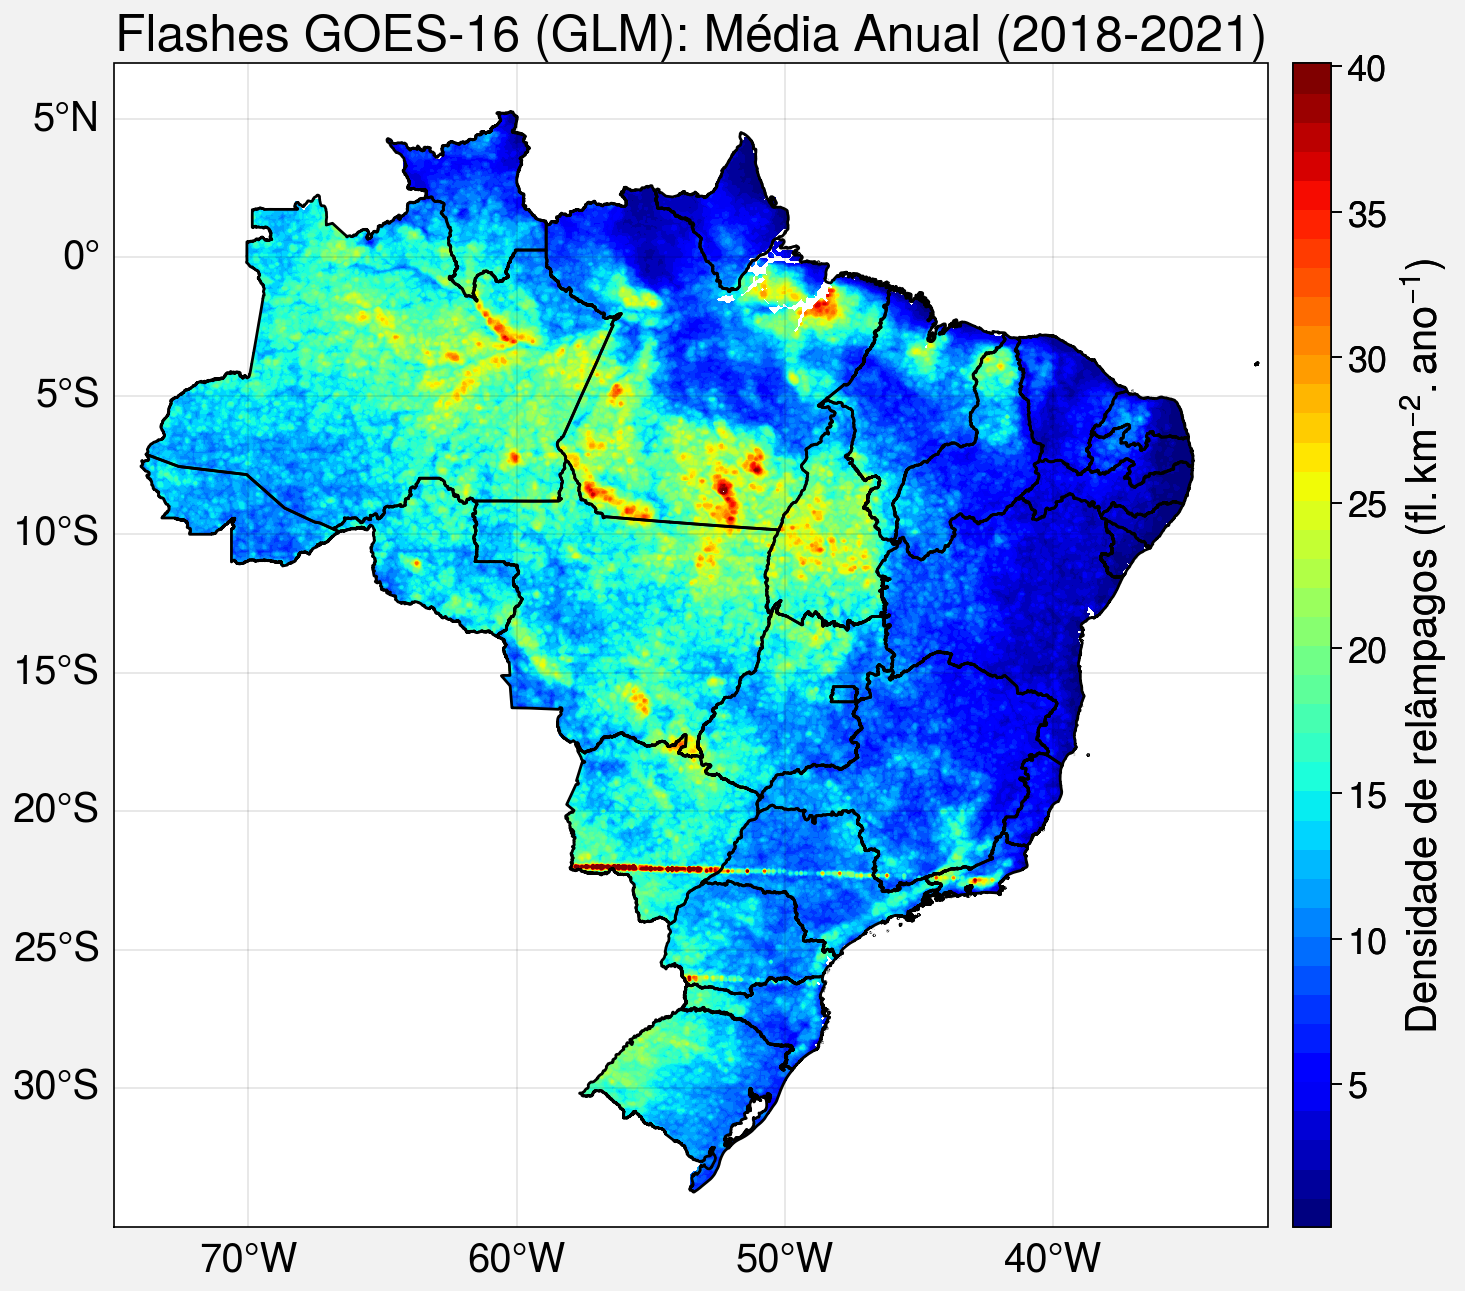

In [ ]:
# cria a moldura da figura
fig, ax = plot.subplots(axwidth=6, tight=True, proj='pcarree')

# define formato da figura
ax.format(coast=False, borders=False, innerborders=False,
          labels=True, latlines=5, lonlines=10,
          latlim=(latmin, latmax), lonlim=(lonmin, lonmax),
          title=f'Flashes GOES-16 (GLM): Média Anual ({flash_por_ano.year[0].values}-{flash_por_ano.year[-1].values})',
          small='20px', large='25px')

# plota mapa
map1 = ax.contourf(flash_media_anual['lon'],
                   flash_media_anual['lat'],
                   flash_media_anual[:,:]/64.,
                   cmap='jet',
                   vmin=0.1, vmax=40,
                   levels=plot.arange(0.1, 40., 1.0))

# plota contorno dos Estados do Brasil
estados.plot(edgecolor='black', facecolor='none', linewidth=1, alpha=1, ax=ax)

# plota barra de cores da figura
fig.colorbar(map1, loc='r', label='Densidade de relâmpagos $(fl.km^{-2}.ano^{-1})$',
             ticks=5, ticklabelsize=13, labelsize=15)

# salva figura
fig.save(f'{dir}output/parte_3/Fig_4_goes16_flash_media_anual_Brasil.jpg', dpi=300)

###**e) Média Sazonal**

**Gera estatísticas**

In [ ]:
# reamostra o dado
flash_media_sazonal = flash_por_mes['flash'].groupby("time.season").mean(dim="time")

In [ ]:
# recorta o dado para região
flash_media_sazonal  = flash_media_sazonal.salem.roi(shape=shapefile_brasil)

In [ ]:
# mostra o dado
flash_media_sazonal

<xarray.DataArray 'flash' (season: 4, lat: 1664, lon: 1664)>
dask.array<where, shape=(4, 1664, 1664), dtype=float32, chunksize=(1, 1664, 1664), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -66.56 -66.48 -66.4 -66.32 ... 66.24 66.32 66.4 66.48
  * lon      (lon) float32 -141.6 -141.5 -141.4 -141.3 ... -8.68 -8.6 -8.52
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Attributes:
    pyproj_srs:  +proj=longlat +datum=WGS84 +no_defs

**Plota gráfico**

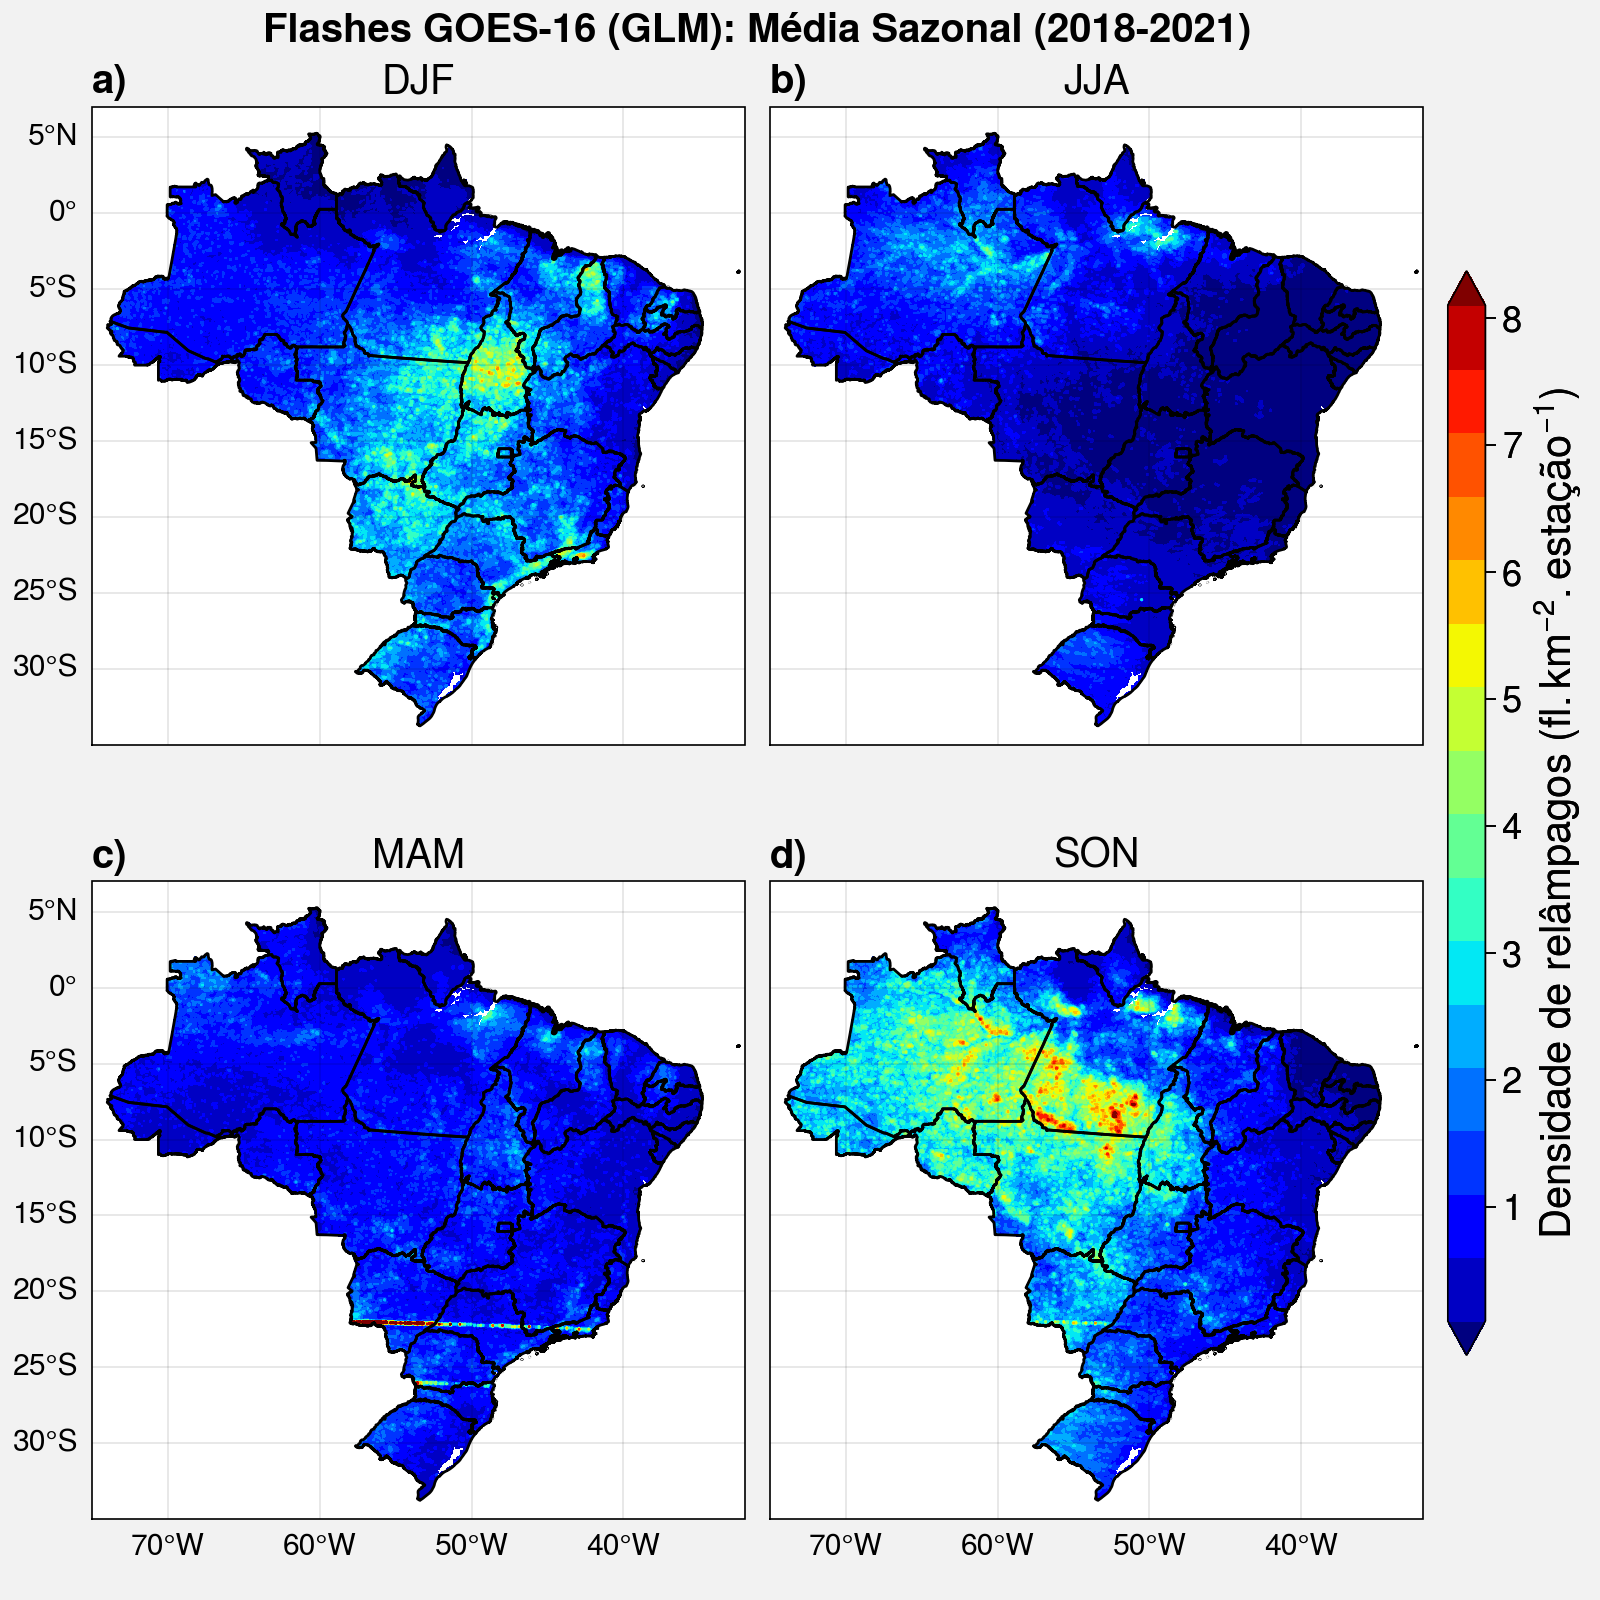

In [ ]:
# cria a moldura da figura
fig, ax = plot.subplots(figsize=(8,8), nrows=2, ncols=2, tight=True, proj='pcarree', sharex=True, sharey=True)

# define formato da figura
ax.format(coast=False, borders=False, innerborders=False,
          labels=True, latlines=5, lonlines=10,
          latlim=(latmin, latmax), lonlim=(lonmin, lonmax),
          suptitle=f'Flashes GOES-16 (GLM): Média Sazonal ({flash_por_ano.year[0].values}-{flash_por_ano.year[-1].values})',
          abc=True, abcstyle='a)', abcsize=5,
          small='15px', large='20px')

# loop das estações
for s in range(len(flash_media_sazonal)):

    # plota figura
    map1 = ax[s].contourf(flash_media_sazonal['lon'], flash_media_sazonal['lat'], flash_media_sazonal[s,:,:]/64.,
                          cmap='jet', levels=plot.arange(0.1, 8., 0.5),
                          extend='both')

    # plota titulo de cada figura
    if(s == 0): ax[s].format(title=flash_media_sazonal.season[s].values, labels = [True, False, False, False])
    if(s == 1): ax[s].format(title=flash_media_sazonal.season[s].values, labels = [False, False, False, False])
    if(s == 2): ax[s].format(title=flash_media_sazonal.season[s].values, labels = [True, False, True, False])
    if(s == 3): ax[s].format(title=flash_media_sazonal.season[s].values, labels = [False, False, True, False])

    # plota o contorno dos Estados do Brasil
    shapefile = list(shpreader.Reader(f'{dir}shapefiles/BR_UF_2019.shp').geometries())
    ax[s].add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='black',facecolor='none', linewidth=1.0)

# plota barra de cores da figura
fig.colorbar(map1, loc='r', label='Densidade de relâmpagos $(fl.km^{-2}.estação^{-1})$',
             ticks=1, ticklabelsize=13, labelsize=15, length=0.70)

# salva figura
fig.save(f'{dir}output/parte_3/Fig_5_goes16_flash_media_sazonal_Brasil.jpg', dpi=300)

###**f) Média Mensal**

**Gera estatísticas**

In [ ]:
# reamostra o dado
flash_media_mensal = flash_por_mes['flash'].groupby('time.month').mean(dim='time')

In [ ]:
# recorta o dado para região
flash_media_mensal = flash_media_mensal.salem.roi(shape=shapefile_brasil)

In [ ]:
# mostra o dado
flash_media_mensal

<xarray.DataArray 'flash' (month: 12, lat: 1664, lon: 1664)>
dask.array<where, shape=(12, 1664, 1664), dtype=float32, chunksize=(1, 1664, 1664), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -66.56 -66.48 -66.4 -66.32 ... 66.24 66.32 66.4 66.48
  * lon      (lon) float32 -141.6 -141.5 -141.4 -141.3 ... -8.68 -8.6 -8.52
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    pyproj_srs:  +proj=longlat +datum=WGS84 +no_defs

**Plota gráfico**

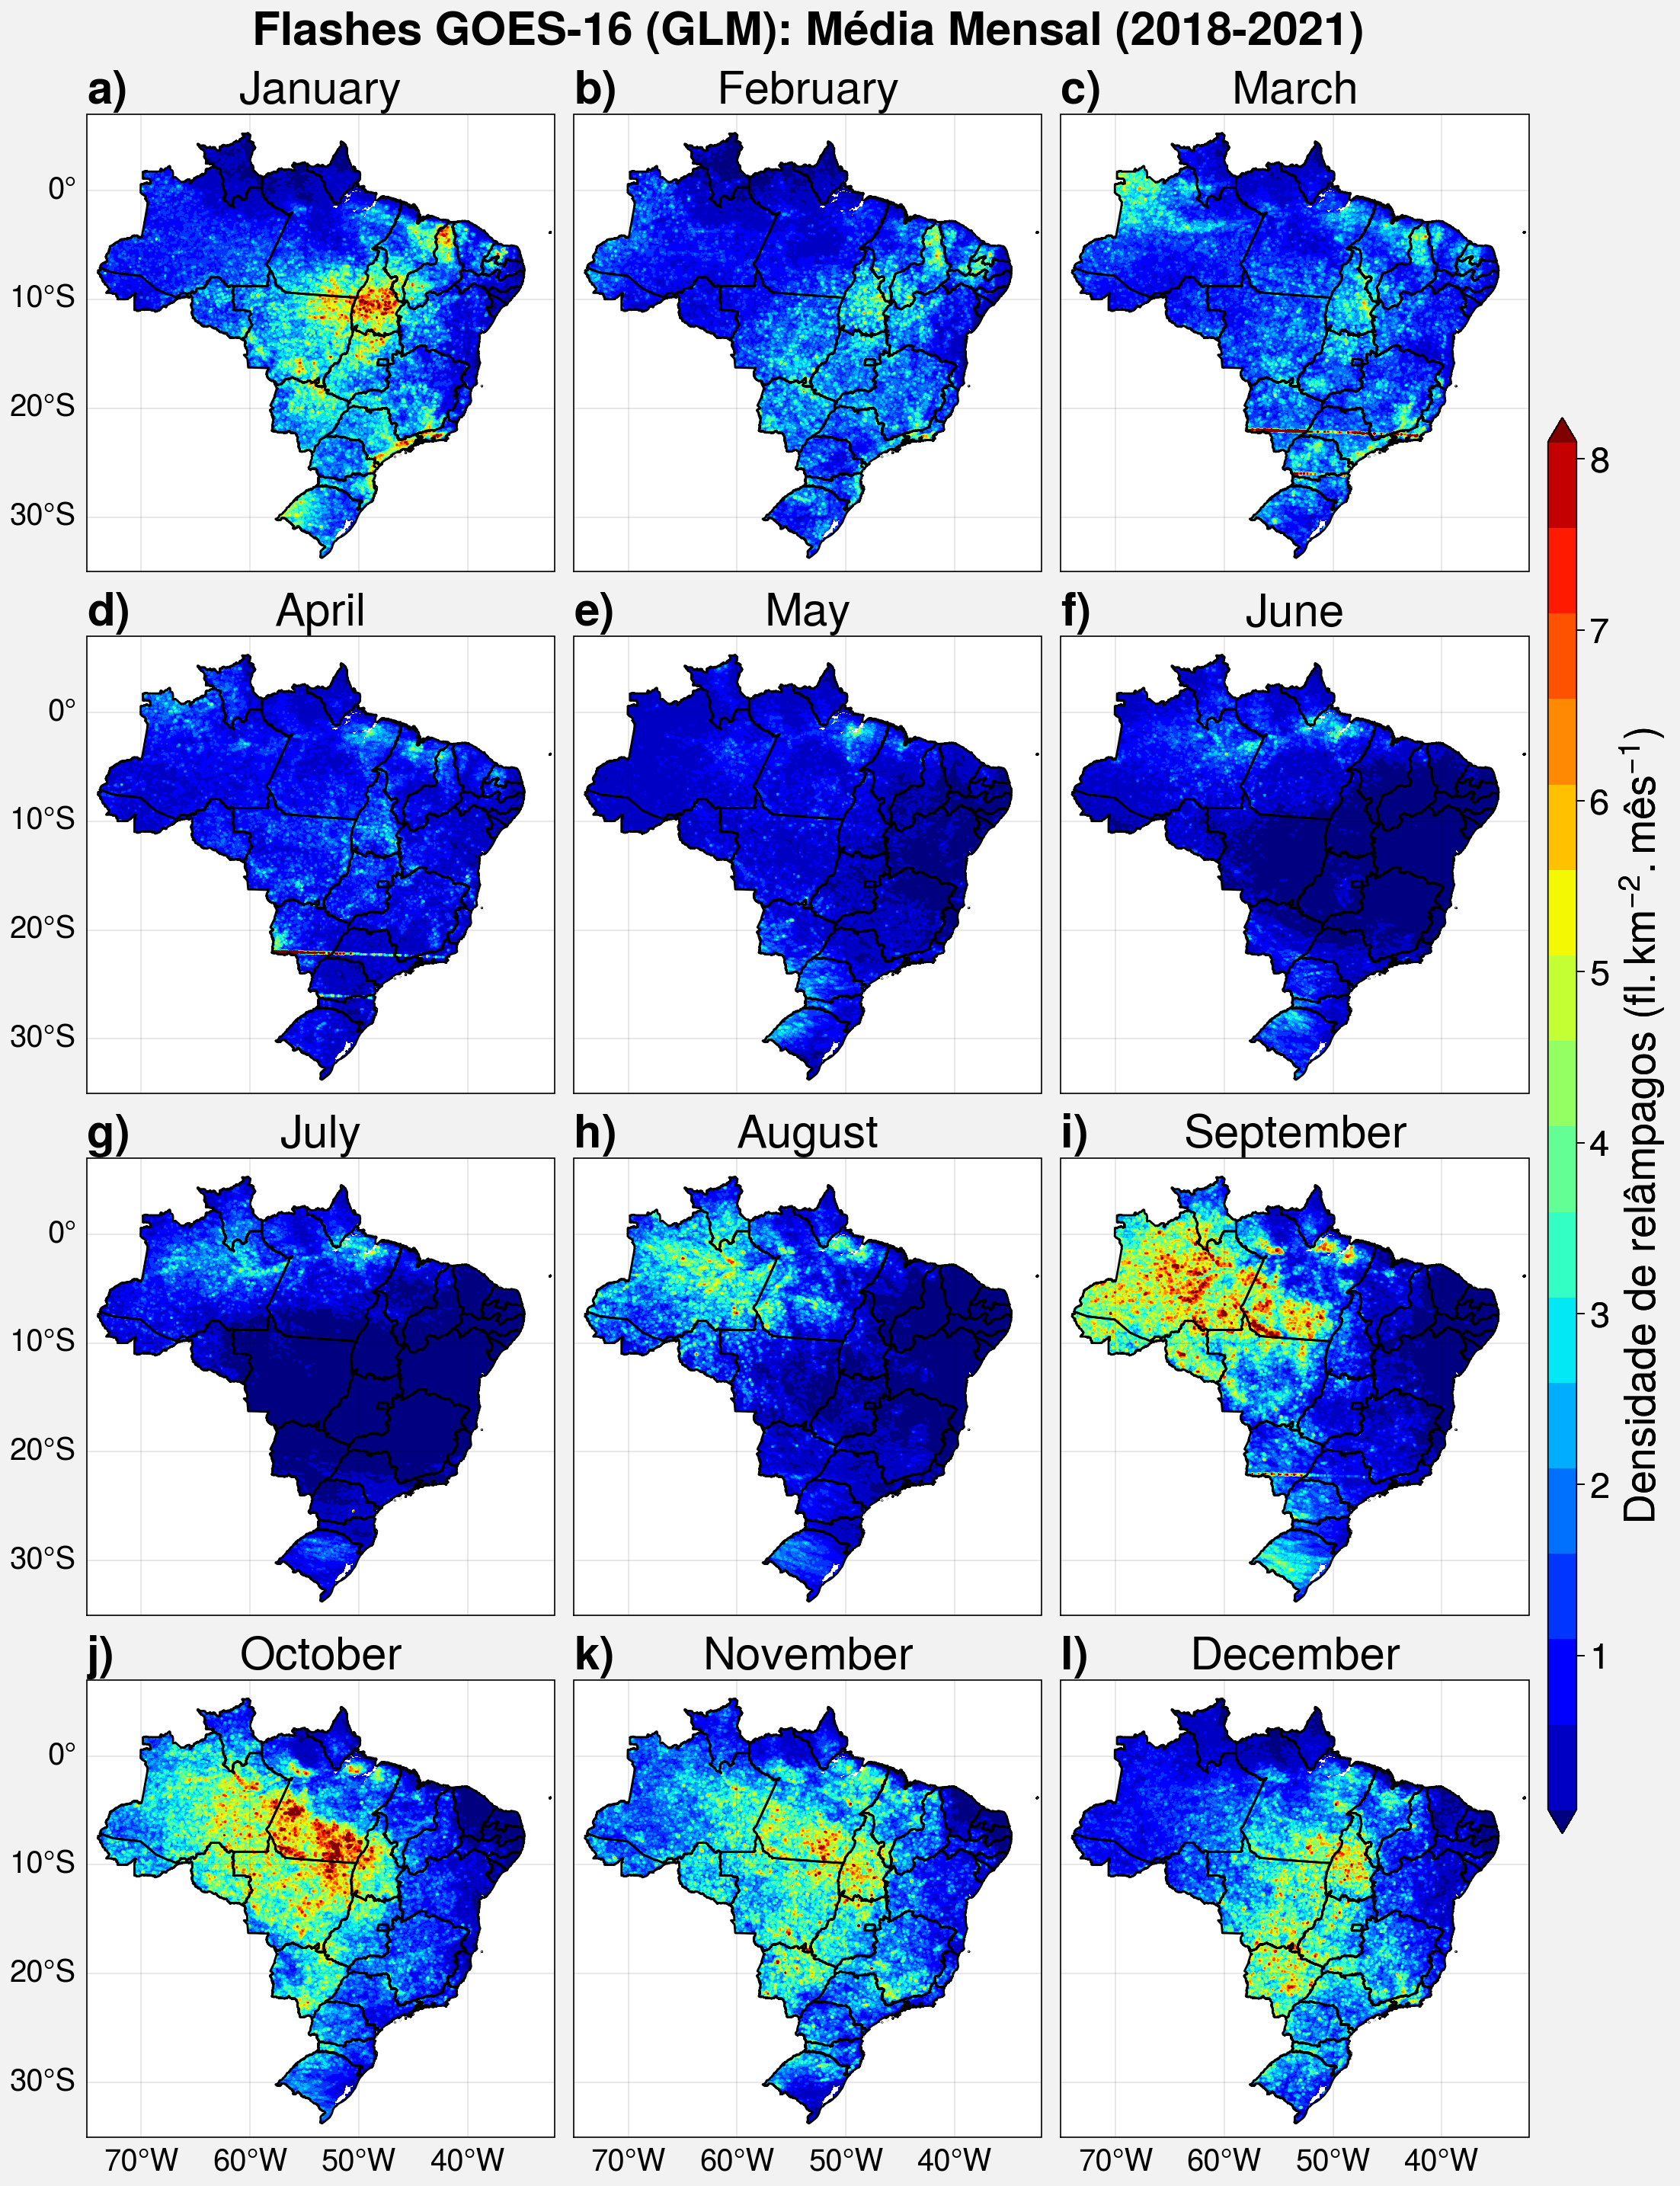

In [ ]:
# cria a moldura da figura
fig, ax = plot.subplots(ncols=3, nrows=4, axheight=3, tight=True, proj='pcarree', sharex=True, sharey=True)

# formatação dos eixos
ax.format(coast=False, borders=False, innerborders=False,
          labels=True, latlines=10, lonlines=10,
          latlim=(latmin, latmax), lonlim=(lonmin, lonmax),
          suptitle=f'Flashes GOES-16 (GLM): Média Mensal ({flash_por_ano.year[0].values}-{flash_por_ano.year[-1].values})',
          abc=True, abcstyle='a)', abcsize=5,
          small='20px', large='30px')

# loop dos meses
for m in np.arange(0, 12):

    # nome do mês
    mes = str(m+1).zfill(2)

    # plota figura
    if m == 0:
        map1 = ax[m].contourf(flash_media_mensal['lon'], flash_media_mensal['lat'], flash_media_mensal[m,:,:]/64.,
                              cmap='jet',
                              levels=plot.arange(0.1, 8., 0.5),
                              extend='both')
    else:
        ax[m].contourf(flash_media_mensal['lon'], flash_media_mensal['lat'], flash_media_mensal[m,:,:]/64.,
                       cmap='jet',
                       levels=plot.arange(0.1, 8., 0.5),
                       extend='both')

    # plota titulo de cada figura
    if (m==1 or m==2 or m==4 or m==5 or m==7 or m==8): ax[m].format(title=calendar.month_name[int(m+1)], labels=False)
    if (m==10 or m==11): ax[m].format(title=calendar.month_name[int(m+1)], labels=[False, False, True, False])
    if (m==0 or m==3 or m==6): ax[m].format(title=calendar.month_name[int(m+1)], labels=[True, False, False, False])
    if (m==9): ax[m].format(title=calendar.month_name[int(m+1)], labels=[True, False, True, False])

    # plota o contorno dos Estados do Brasil
    shapefile = list(shpreader.Reader(f'{dir}shapefiles/BR_UF_2019.shp').geometries())
    ax[m].add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='black',facecolor='none', linewidth=1.0)

# plota barra de cores da figura
fig.colorbar(map1, loc='r', label='Densidade de relâmpagos $(fl.km^{-2}.mês^{-1})$',
             ticks=1, ticklabelsize=17, labelsize=20, length=0.70)

# salva figura
fig.save(f'{dir}output/parte_3/Fig_6_goes16_flash_media_mensal_Brasil.jpg', dpi=300)